In [1]:
# User-provided utility functions
from utils.tk_utils import *
from utils.data_funcs import *

# For exporting images
import os

# Prophet libraries
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from fbprophet.utilities import regressor_coefficients

In [2]:
# Set maximum display rows and columns for Pandas. These were here so that
# we could validate / verify our dataframe.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Facebook Prophet

The Facebook Prophet equation is decomposed as follows:

$$ y(t) = g(t) + s(t) + h(t) + e(t) $$

where:
   1. $g(t)$ is the component that models non-periodic trends (such as the growth over time). In this case, any of our COVID metrics should suffice (like number of cases, deaths)
   2. $s(t)$ is the component that models periodic trends (e.g, weekly, monthly, yearly patterns). The mobility data should go inside here since it exhibits periodic patterns and mobility is correlated with policy effects.
   3. $h(t)$ is the component that models irregular, holiday effects. The list of country specific holidays should go into holiday components, as well as policy changes since they are announced exactly at certain points but do not exhibit regular pattern changes. This is where we can potentially modify the list of policy changes and observe if trendlines will differ.
   4. $e(t)$ accounts for noise terms. We will disregard this for now.

# Creating the dataframes for a basic model

Before we can do any sort of model training, we will create a basic dataframe that contains all information regarding the desired COVID
output metrics for a given state and the policies (including policy levels) that were in effect for each date for the same state. For
our starting point, we chose to only look at stay-at-home policies for the state of California. The code cell below synthesizes
the state-policy dataframe for California between the start of 2020 to the most recent date (which was last updated to May 21st).

In [3]:
# Policies we choose which we want to analyze effectiveness for
policies = ['c6_stay_at_home_requirements']

# Make a copy of the OxCGRT policy dataframe with only the USA data
us_filled_policy_data_df = get_state_policy_data()

# Make a copy of the NYT state covid daily data of new cases and new deaths
us_state_daily = get_state_covid_daily_data()

# Start date and end date we want to look at for the COVID output metrics
start_date = '2020-01-01'
end_date = '2021-05-21'
state = 'California'

# Make new policy dataframe and make a state policy date frame from it
policy_df = make_state_policy_df(us_filled_policy_data_df, us_state_daily, start_date, end_date, state)
state_df = get_df_by_dates(make_policy_changes_df(policy_df, policies), start_date, end_date)

# Get the 7 day average of daily new cases from each date
state_df['7_day_avg'] = state_df['cases'].rolling(window=7).mean()

# Get the cumulative cases of a month from each date
cum_df = get_future_cum_cases(state_df, window=30)
state_df['month_cumu_cases'] = cum_df
state_df.head()

C:\Users\TK-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


date       state  cases  deaths  c6_stay_at_home_requirements  \
0 2020-01-25  California    1.0     0.0                           0.0   
1 2020-01-26  California    1.0     0.0                           0.0   
2 2020-01-27  California    0.0     0.0                           0.0   
3 2020-01-28  California    0.0     0.0                           0.0   
4 2020-01-29  California    0.0     0.0                           0.0   

   7_day_avg  month_cumu_cases  
0        NaN               9.0  
1        NaN              10.0  
2        NaN               9.0  
3        NaN              24.0  
4        NaN              24.0

We also want to figure out the number of policy changes for the given policies we have chosen above (stay-at-home) throughout the duration of this dataframe. This is accomplished using the utility function `get_number_of_policy_changes`, which is detailed in the `tk_utils.py` file.

In [4]:
# Get the number of policy changes for the policies
(pchange_df, counts) = get_number_of_policy_changes(state_df, policies)

Just looking at the policy changes isn't enough, we also would like to look specifically at instances where such policies were changed independently of the other policies. The function `get_isolated_policy_counts_and_dates` does exactly this, and the specific instances where this happened accomplish this.

In [5]:
# Get the isolated policy changes and their corresponding policies for the policies we chose above
(counts_isolated, isolated_dates) = get_isolated_policy_counts_and_dates(pchange_df, policies)

## Preliminary plots of the COVID output metrics

We will first start by just plotting the COVID output metric for the given state (which in this case is California). We have
smoothed out the COVID output metric by taking the 7-day average of the cases as well as calculate the monthly cumulative cases
starting for each date, so we'll plot both output metrics below!

In [6]:
fig = px.line(state_df, x="date", y="7_day_avg", labels={'date' : 'date', '7_day_avg' : '7 Day Avg of New Cases'})
fig.show()

In [7]:
fig = px.line(state_df, x="date", y="month_cumu_cases", labels={'date' : 'date', 'month_cumu_cases' : 'Monthly cumulative cases'})
fig.show()

Observe that there are very 2 defined spikes - one during the summer and one during the winter around holiday season. Based on our preliminary
data analysis in the `cs156b_plots_tk` file, we know there were policy changes (especially for stay-at-home policy) approximately
before each spike happen. This makes the time periods around these spikes prime targets for training periods, as we are very likely to
extract useful information regarding policy effectiveness from these spikes.

# Building a basic Prophet model

The below models only consider the 7-day avg number of new cases (as our $g(t)$) to predict the number of new cases. We will see how good the predictions are first before we actually add in our periodic trends and holiday effects.

In [8]:
# Training parameters for our model
train_start = '2020-03-01'
train_end = '2020-12-01'
period = 90
err_metric = 'r2'

# Initialize new prophet with yearly seasonality built in
prophet = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
      # really have an additive effect here
    # Below are regularization terms basically. All of these terms are using
    # default numbers
    seasonality_prior_scale=1, # Regularization term for seasonality. The lower, the more regularized
)

(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    include_history=True
)

fc_df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-03-01 -393.907115 -670.348408  271.604732  -393.907115  -393.907115   
1 2020-03-02 -357.722735 -648.996839  293.690923  -357.722735  -357.722735   
2 2020-03-03 -321.538356 -596.381801  387.940354  -321.538356  -321.538356   
3 2020-03-04 -285.353976 -561.462026  406.390427  -285.353976  -285.353976   
4 2020-03-05 -249.169596 -574.251396  405.264740  -249.169596  -249.169596   

   multiplicative_terms  multiplicative_terms_lower  \
0             -0.462451                   -0.462451   
1             -0.532334                   -0.532334   
2             -0.599562                   -0.599562   
3             -0.664002                   -0.664002   
4             -0.728167                   -0.728167   

   multiplicative_terms_upper    weekly  weekly_lower  weekly_upper    yearly  \
0                   -0.462451 -0.002593     -0.002593     -0.002593 -0.459857   
1                   -0.532334  0.001442      0.001442      0.001442 -0.533776   
2                   -0.599562  0.003899      0.003899      0.003899 -0.603461   
3                   -0.664002  0.003580      0.003580      0.003580 -0.667582   
4                   -0.728167 -0.003255     -0.003255     -0.003255 -0.724912   

   yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0     -0.459857     -0.459857             0.0                   0.0   
1     -0.533776     -0.533776             0.0                   0.0   
2     -0.603461     -0.603461             0.0                   0.0   
3     -0.667582     -0.667582             0.0                   0.0   
4     -0.724912     -0.724912             0.0                   0.0   

   additive_terms_upper        yhat  
0                   0.0 -211.744528  
1                   0.0 -167.294851  
2                   0.0 -128.756080  
3                   0.0  -95.878334  
4                   0.0  -67.732518

From the forecast, seems like only `yhat`, `yhat_lower`, `yhat_upper` is relevant since these are our y-predictions and its confidence interval is stored in these columns. We will then look at compare the resulting forecast curve with the actual case values and see whether an initial model fits the data well.

In [9]:
# Display actual-predicted plot
p.show()

In [10]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [11]:
print("{0}: {1}".format(err_metric, err))

r2: 0.3312019070724518


## Observations

Our initial model (which was trained on the first 6 months in California) seems to fit to the training data fine, but did not perform really well on the testing dataset. This is because the model is entirely dependent of yearly and weekly trend, which is not sufficient enough to really establish a clear pattern in the case trends. This initial model also does not take into account the effects of the policies, which is what we really want to focus on and what we will be adding later on.

# Adding policies as more regressors into the basic model

In this model, we will try to add the effect of each policy we deem important into the Prophet model as extra regressors. We will also add U.S holidays to account for holiday trends as well. We will try to observe if providing the policy levels as regressors will help the model adjust and fit to our testing data better. We will experiment later to see if treating the policies as holiday events will allow us to capture the effects of policies on the actual COVID output metric as well.

In [12]:
# Right now, just add the level of the policies to the model
colnames = policies

# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='linear', # Plotting this as linear
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=None, # Holidays to be added later
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects. The lower, the more dampened.
                  changepoint_prior_scale=.07 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Add U.S country holidays into consideration
prophet.add_country_holidays(country_name='US')

# Forecast
(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    colnames=colnames,
    include_history=True,
    prior_scale=1
)

# Display plot
p.show()

In [13]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [14]:
print("{0}: {1}".format(err_metric, err))

r2: 0.34716330013352326


From the above plots, the addition of U.S holidays seem to have minimal effects on the trend of the new COVID daily cases. However, the model was able to capture an increase in cases around Independence Day, which corresponds to the spike during summer. This makes sense considering that stay-at-home policy was relaxed earlier in California early may, and a large national holiday would likely draw huge crowds, resulting in spread of infections.

Adding policies as extra regressors do not seem to have large effect on the COVID output trajectory. This suggests that policy levels are not really good indicators of how effective the policy will be at reducing the number of cases, as it doesn't suggest a policy change that could potentially alter the trajectory of the growth curve. 

There are a few possible issues with the above models, as it assumes the disease trend growth is linear, when it is usually logistic.

## Modeling counterfactual and comparing our results to the above model

We will then look at the counterfactual forecast curve where we don't include U.S holidays nor the policy levels as regressors and observe the difference between this and the forecasting curve to note any effects policy changes may have.

In [15]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='linear', # Plotting this as linear
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects 
                  changepoint_prior_scale=.07 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast
(cfc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    include_history=True
)

In [16]:
# Plots the counterfactual vs. forecast and actual cases plot
actual_df = convert_df_to_input_df(
    get_df_by_dates(state_df, start_date=train_start, end_date=fc_df['ds'].max()), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

## Looking at changepoints in the trends to provide observations to how well the model is performing

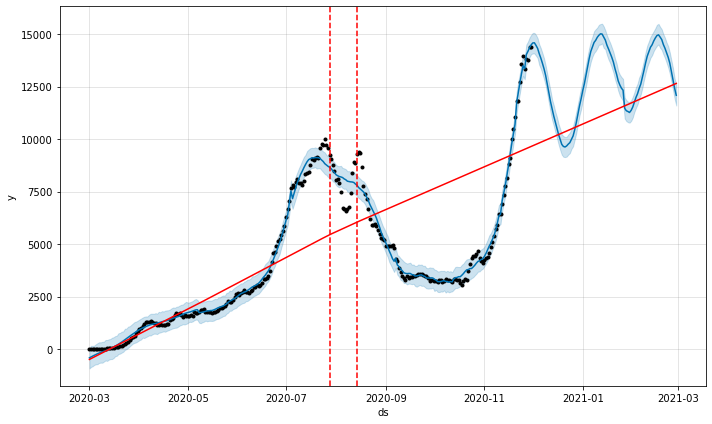

In [17]:
fig = prophet.plot(fc_df)
a = add_changepoints_to_plot(fig.gca(), prophet, fc_df)

It doesn't look like our model is detecting any changepoints, but this makes sense because our current changepoint term is only `0.07`, we will experiment with increasing that since it seems like model isn't fitting well right now.

# Linear growth Prophet model, but modeling isolated policy changes as holidays

For our next attempt, we will look at modeling isolated policy changes as holiday effects and see whether policy effects on
the COVID output metrics are captured this way.

## Making the collective isolated policy change dataframe

In [18]:
policy_dfs = []

# Lag period since we want to observe the 2-week long-term effects on the number of cases post a policy change
lag_period = 14

# We will make a separate holiday dataframe for each policy and the corresponding dates of isolated policy change
# to study effects of the policies on forecasting
for policy in isolated_dates:
    policy_df = make_holiday_df(policy, isolated_dates[policy], 0, lag_period)
    policy_dfs.append(policy_df)

# Concatenate all holiday dataframes into a single dataframe containign the isolated policy change dates for each policy
final_holiday_df = pd.concat(policy_dfs)
final_holiday_df.head()

holiday         ds  lower_window  upper_window
0  holiday_c6_stay_at_home_requirements 2020-01-25             0            14
1  holiday_c6_stay_at_home_requirements 2020-03-11             0            14
2  holiday_c6_stay_at_home_requirements 2020-03-17             0            14
3  holiday_c6_stay_at_home_requirements 2020-05-08             0            14
4  holiday_c6_stay_at_home_requirements 2020-11-21             0            14

We will reuse the model from above, but set our holiday dataframe for the Prophet model to be the holiday dataframe we used above. We will also adjust the change point regularizion term so the model detects more change points in the COVID trend curve.

In [19]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='linear', # Plotting this as linear
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Isolated policy changes are modeled as holidays here
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects. The lower, the more dampened. 
                  changepoint_prior_scale=.1 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast
(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    include_history=True
)

# Plot model with isolated policy changes as holidays
p.show()

In [20]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [21]:
print("{0}: {1}".format(err_metric, err))

r2: 0.32644824354469015


## Counterfactual 2

In [22]:
actual_df = convert_df_to_input_df(
    get_df_by_dates(state_df, start_date=train_start, end_date=fc_df['ds'].max()), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

## Observations

The model here detects a spike everytime a stay-at-home policy was changed. However, since we are not currently determining whether a change resulted in a more relaxed or tightened stay-at-home order, it is very difficult to isolate the effects of each on the COVID output metrics. Not to mention, it seems like each stay-at-home order has the same effect rather than being adjusted depending on different occurrences, indicating that the model seems to just be using prior assumptions from earlier policy changes rather than looking potential new changes.

# What about modeling all policy change dates as holidays instead of just the isolated ones?

Looking at only isolated policy changes might not provide us with enough data points to measure policy effectiveness. We will look at all policy change dates, but separate between dates when a policy was tightened or relaxed to look at their individual effects.

In [23]:
policy_dfs = []
split = True

# Create our holiday dataframe
if split:
    for policy in policies:
        (tdates, rdates) = get_policy_change_dates(state_df, policy, split=split)
        tight_df = make_holiday_df(policy + '_tightened', tdates, 0, 1)
        relaxed_df = make_holiday_df(policy + '_relaxed', rdates, 0, 1)
        policy_df = pd.concat([tight_df, relaxed_df])
        policy_df = find_upper_window(policy_df, state_df['date'].max())
        policy_dfs.append(policy_df)
else:
    # We will make a separate holiday dataframe for each policy and the corresponding change dates for each policy
    for policy in policies:
        policy_df = make_holiday_df(policy, get_policy_change_dates(state_df, policy), 0, 1)
        policy_df = find_upper_window(policy_df, state_df['date'].max())
        policy_dfs.append(policy_df)
        
# Concatenate all holiday dataframes into a single dataframe containign the isolated policy change dates for each policy
final_holiday_df = pd.concat(policy_dfs)
final_holiday_df.head()

holiday         ds  lower_window  \
0  holiday_c6_stay_at_home_requirements_tightened 2020-03-11             0   
1  holiday_c6_stay_at_home_requirements_tightened 2020-03-17             0   
4    holiday_c6_stay_at_home_requirements_relaxed 2020-05-08             0   
2  holiday_c6_stay_at_home_requirements_tightened 2020-11-21             0   
5    holiday_c6_stay_at_home_requirements_relaxed 2021-01-27             0   

   upper_window  
0             5  
1            51  
4            90  
2            66  
5            47

In [24]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='linear', # Plotting this as linear
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Isolated policy changes are modeled as holidays here
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects 
                  changepoint_prior_scale=.07 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast
(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    include_history=True
)

# Plot model with ALL policy changes as holidays
p.show()

In [25]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [26]:
print("{0}: {1}".format(err_metric, err))

r2: 0.24616471346441982


## Counterfactual 3

In [27]:
actual_df = convert_df_to_input_df(
    get_df_by_dates(state_df, start_date=train_start, end_date=fc_df['ds'].max()), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

# What if we try both policy levels as regressors and policy change dates as holidays?

The following model was just an experiment to see the effects of putting policy levels as additional model regressors as well as policy change dates as holiday effects.

In [28]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='linear', # Plotting this as linear
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Holidays to be added later
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects. The lower, the more dampened.
                  changepoint_prior_scale=0.07 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast
(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    colnames=colnames,
    include_history=True)

# Plot model with ALL policy changes as holidays and policy levels are regressors
p.show()

In [29]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [30]:
print("{0}: {1}".format(err_metric, err))

r2: 0.3913581804037449


The estimated beta coefficient (below) for each regressor roughly represents the increase in prediction value for a unit increase in the regressor value (note that the coefficients returned are always on the scale of the original data).

In [31]:
# Get additional regressor coefficients
regressor_coefficients(prophet)

regressor  regressor_mode    center  coef_lower  \
0  c6_stay_at_home_requirements  multiplicative  1.189091    0.460235   

       coef  coef_upper  
0  0.460235    0.460235

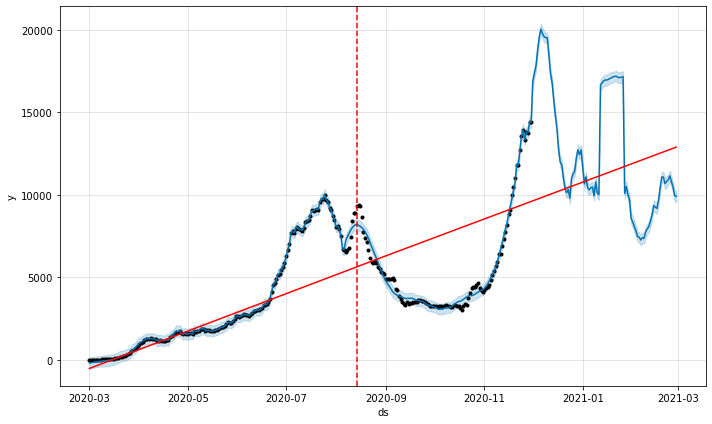

In [32]:
fig = prophet.plot(fc_df)
a = add_changepoints_to_plot(fig.gca(), prophet, fc_df)

## Counterfactual 4

In [33]:
actual_df = convert_df_to_input_df(
    get_df_by_dates(state_df, start_date=train_start, end_date=fc_df['ds'].max()), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

# Using logistic growth to plot the COVID cases based on policies

From our observations above, it seems like modeling the COVID cases using a linear model is a recipe for disaster (as linear trends can dip into the negatives). We will try to replace the non-period trend with a logistic curve, which will require us to find the floor (saturating minimum) and ceiling (carrying capacity) for the cases. For the saturating minimum, we will just use `0` since the number of cases will never dip below 0. For the carrying capacity, we will estimate this number by doing some nonlinear least squares estimation. See https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2 for full reference.

## Curve-fitting a logistic growth curve to generate the carrying capacity for the Prophet model

To curve-fit our logistic curve, we need to select a training period so we can extract the data from the actual COVID case curve and fit our growth function to the data. Note that we can only pick periods where there is clear sign of of a logistic growth (or decay), so in the below cell, we are picking the period right after the first spike and before the second spike peak since that closely observes the logistic function we want to look at.

In [34]:
train_start = '2020-09-15'
train_end = '2020-12-15'
period = 30

# Get the input dataframe for the training period
input_df = convert_df_to_input_df(
    get_df_by_dates(state_df, train_start, train_end), 
    '7_day_avg')

In [35]:
# Randomly initializes the values for C_min, C_max, r, t_mid and alpha
theta0 = [0., 20000., 1, 50., 2.]
lower_bounds = [0., 0., -1000., -100., -1000.]
upper_bounds = [10000., 40000., 1000., 200., 1000.]

# Using the optimizer from SciPy, we find our optimal parameters for the lgostic curve.
input_df, (C_min_opt, C_max_opt, r_opt, t_mid_opt, eps_opt) = find_optimal_params(lower_bounds, upper_bounds, input_df, gen_logistic_func, theta0=theta0)

In [36]:
print(
'''Optimal parameters:
    C_min_opt: {0}
    C_max_opt: {1}
    r_opt: {2}
    t_mid_opt: {3}
    eps_opt: {4}
'''.format(C_min_opt, C_max_opt, r_opt, t_mid_opt, eps_opt))

Optimal parameters:
    C_min_opt: 3487.7122463496885
    C_max_opt: 39999.99996917299
    r_opt: 1.9720378434156465
    t_mid_opt: 53.64473596739089
    eps_opt: 18.605470467250242



We will measure the accuracy of our logistic curve fit by plotting the COVID output metric generated by the curve-fitted logistic growth function versus the actual values.

In [37]:
# Plot the fitted logistic curve against the actual cruve
y_fitted = gen_logistic_func(input_df['t'], C_min_opt, C_max_opt, r_opt, t_mid_opt, eps_opt)
plot_curve_fit(input_df, y_fitted)

It seems like our logistic function fits pretty well to the training data. However, this is not always the case. If we were to only consider a flat part of the training data (maybe stopping before Nov 22), the peak estimated by our logistic growth curve would've been much smaller.

## Using the curve-fitted logistic growth function to train our Prophet model with policies modeled as holiday effects

We will first create our carrying capacity dataframe using the resulting logistic curve we fitted from above. This will be used to provide the carrying capacity for both our training data and our forecasting period.

In [38]:
# Make the carrying capacity dataframe
(fc_start, fc_end) = get_forecast_intervals(train_end, period, '%Y-%m-%d')
caps_timesteps = generate_timesteps(train_start, fc_end.strftime('%Y-%m-%d'))
caps = gen_logistic_func(caps_timesteps, C_min_opt, C_max_opt, r_opt, t_mid_opt, eps_opt)
caps_dt = generate_datetimes(train_start, fc_end.strftime('%Y-%m-%d'))
caps_dict = {'ds': caps_dt, 'cap' : caps}
caps_df = pd.DataFrame(data=caps_dict)
caps_df.head()

ds          cap
0 2020-09-15  3494.370343
1 2020-09-16  3495.114656
2 2020-09-17  3495.942158
3 2020-09-18  3496.862142
4 2020-09-19  3497.884937

In [39]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='logistic', # Plotting this as logistic
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Isolated policy changes are modeled as holidays here
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.01, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects 
                  changepoint_prior_scale=.1 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast
(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    include_history=True,
    caps_df=caps_df,
    prior_scale=1,
)

# Plot the fitted logistic growth model
p.show()

In [40]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [41]:
print("{0}: {1}".format(err_metric, err))

r2: 0.9655533132350308


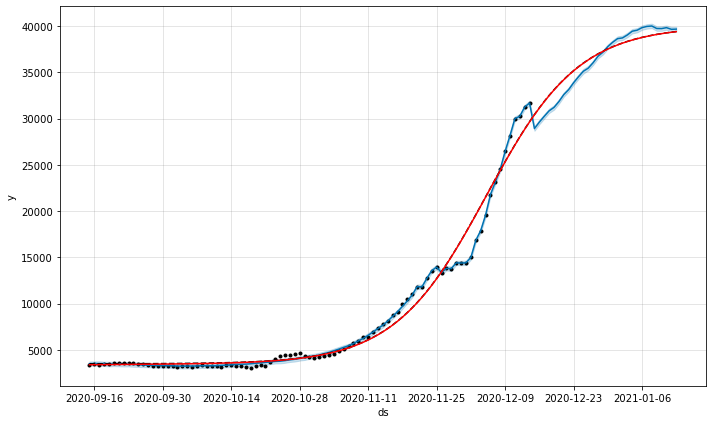

In [42]:
fig = prophet.plot(fc_df)
a = add_changepoints_to_plot(fig.gca(), prophet, fc_df)

## Looking at counterfactual in the same training period

In [43]:
# Same model as above, but with the holiday dataframe removed
prophet = Prophet(growth='logistic', # Plotting this as logistic
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.01, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects 
                  changepoint_prior_scale=.07 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )


# Forecast
(cfc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    include_history=True,
    caps_df=caps_df
)

## Counterfactual 5

In [44]:
actual_df = convert_df_to_input_df(
    get_df_by_dates(state_df, start_date=train_start, end_date=fc_df['ds'].max()), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

## What about using policy levels as regressors as well?

In [45]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='logistic', # Plotting this as logistic
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Isolated policy changes are modeled as holidays here
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects 
                  changepoint_prior_scale=.07 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast with additional column names
(fc_df, p, err) = prophet_forecast(
    prophet, state_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    colnames=colnames,
    include_history=True,
    caps_df=caps_df)

# Plot the fitted logistic growth model
p.show()

In [46]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [47]:
# Get additional regressor coefficients
regressor_coefficients(prophet)

regressor  regressor_mode    center  coef_lower  \
0  c6_stay_at_home_requirements  multiplicative  1.263736   -0.066535   

       coef  coef_upper  
0 -0.066535   -0.066535

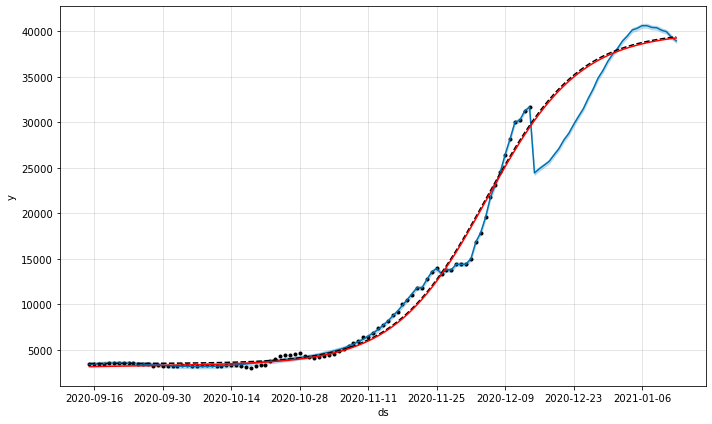

In [48]:
fig = prophet.plot(fc_df)
a = add_changepoints_to_plot(fig.gca(), prophet, fc_df)

## Counterfactual 6

In [49]:
actual_df = convert_df_to_input_df(
    get_df_by_dates(state_df, start_date=train_start, end_date=fc_end), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

# Adding Mobility data as additional regressors to help with policy compliance

One of things we wanted to address was so distinguish between the effects of the same policies enacted in different time periods. This is especially relevant for a tightened stay-at-home policy the first time early pandemic compared to say, the second time around holiday season when there might've been stay-at-home fatigue accumulate. We will try looking at mobility data as an additional regressor in the model with policy effects still modeled as holiday effects.


In [50]:
# Create mobility-state-policy dataframe for California
mobility_df = get_at_away_6_data()
ca_mobil_df = add_mobility_data_to_state_df(mobility_df, state_df, state)
ca_mobil_df.head()

date     state_x  cases  deaths  c6_stay_at_home_requirements  \
0 2020-01-25  California    1.0     0.0                           0.0   
1 2020-01-26  California    1.0     0.0                           0.0   
2 2020-01-27  California    0.0     0.0                           0.0   
3 2020-01-28  California    0.0     0.0                           0.0   
4 2020-01-29  California    0.0     0.0                           0.0   

   7_day_avg  month_cumu_cases     state_y  mobile_ppl_per100  
0        NaN               9.0  California           5.676287  
1        NaN              10.0  California           5.642540  
2        NaN               9.0  California           6.081676  
3        NaN              24.0  California           6.190506  
4        NaN              24.0  California           6.169491

## Training a model with mobility data as additional regressor and policy as holiday effects

The model below is similar to model with all policy change dates as holiday effects except now we have mobility data as an additional regressor.

In [51]:
# Change additional regressors to now include only mobility data
colnames = ["mobile_ppl_per100"]

In [52]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='logistic', # Plotting this as logistic
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Isolated policy changes are modeled as holidays here
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.01, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=20, # Regularization term for holiday effects 
                  changepoint_prior_scale=0.1 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast with additional column names
(fc_df, p, err) = prophet_forecast(
    prophet, ca_mobil_df, 
    train_start, train_end, 
    period, '7_day_avg', 
    err_metric=err_metric,
    colnames=colnames,
    include_history=True,
    caps_df=caps_df,
    prior_scale=10)

# Plot the fitted logistic growth model
p.show()

In [53]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [54]:
# Get additional regressor coefficients
regressor_coefficients(prophet)

regressor  regressor_mode    center  coef_lower      coef  \
0  mobile_ppl_per100  multiplicative  4.751069    0.002818  0.002818   

   coef_upper  
0    0.002818

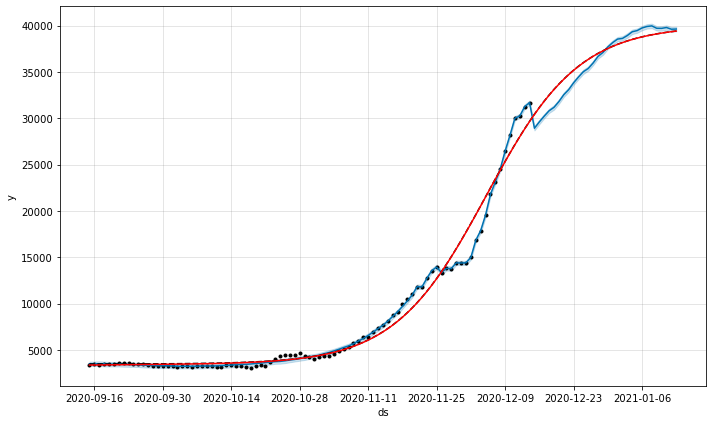

In [55]:
fig = prophet.plot(fc_df)
a = add_changepoints_to_plot(fig.gca(), prophet, fc_df)

## Observations

It seems like mobility data has very minimal effects on the COVID cases itself even with little to no regularization. The pattern that it exhibits is also rather counterintuitive - since mobility data early fall indicates that there was less traffic activity compared to the holiday season. Yet, the components plot seem to indicate that the mobility data regressors indicate that there was a small decrease in the case numbers around the holiday season (which is not true at all) whereas there was a slight rise in cases early fall.

## Counterfactual 6

In [56]:
actual_df = convert_df_to_input_df(
    get_df_by_dates(ca_mobil_df, start_date=train_start, end_date=fc_end), 
    '7_day_avg', additional_cols=colnames)  

p = plot_counterfactual_forecast_actual(actual_df, fc_df, cfc_df)
p.show()

## Testing out linear growth model with mobility data and policies as holiday effects

In [57]:
# Old training period
train_start = '2020-05-01'
train_end = '2020-08-01'
period = 30

In [ ]:
# Make new prophet model with built-in seasonality, but now we account for holiday effects and policy effects.
# By default, all trend effects are modeled using Fourier order 10
prophet = Prophet(growth='linear', # Plotting this as linear
                  yearly_seasonality=True, # Removing yearly seasonality to focus on policy effects
                  weekly_seasonality=True, # Weekly seasonality should be a thing due to COVID case numbers
                      # lower on the weekends
                  daily_seasonality=False, # Daily seasonality - in terms of hours - doesn't really matter
                  holidays=final_holiday_df, # Isolated policy changes are modeled as holidays here
                  seasonality_mode='multiplicative', # Multiplicative seasonality effect since each regressor doesn't
                      # really have an additive effect here
                  # Below are regularization terms basically. All of these terms are using
                  # default numbers
                  seasonality_prior_scale=0.05, # Regularization term for seasonal effects / regressors
                  holidays_prior_scale=10, # Regularization term for holiday effects 
                  changepoint_prior_scale=0.1 # Adjust the flexibility of the trend changes. The higher, the more changepoints
                      # will be detected
                 )

# Forecast
(fc_df, p, err) = prophet_forecast(
    prophet, ca_mobil_df, 
    train_start, train_end, 
    period, 'month_cumu_cases', 
    err_metric=err_metric,
    include_history=True,
    colnames=colnames,
    prior_scale=10,
)

p.show()

In [ ]:
# Function to plot individual components of the time series
plot_components_plotly(prophet, fc_df)

In [ ]:
# Get additional regressor coefficients
regressor_coefficients(prophet)

In [ ]:
fig = prophet.plot(fc_df)
a = add_changepoints_to_plot(fig.gca(), prophet, fc_df)